In [1]:
using ReinforcementLearning, ReinforcementLearningEnvironments

In [2]:
using RLIntro, RLIntro.RandomWalk

┌ Info: Precompiling RLIntro [02c1da58-b9a1-11e8-0212-f9611b8fe936]
└ @ Base loading.jl:1264
┌ Warning: Package RLIntro does not have StatsBase in its dependencies:
│ - If you have RLIntro checked out for development and have
│   added StatsBase as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with RLIntro
└ Loading StatsBase into RLIntro from project dependency, future warnings for RLIntro are suppressed.


In [11]:
using StatsBase

In [19]:
using Plots

In [3]:
true_values = [i/6 for i in 1:5]

5-element Array{Float64,1}:
 0.16666666666666666
 0.3333333333333333 
 0.5                
 0.6666666666666666 
 0.8333333333333334 

In [6]:
env = RandomWalkEnv(leftreward=0.)
n_states, n_actions = length(observation_space(env)), length(action_space(env))

(7, 2)

In [16]:
struct RecordRMS <: AbstractHook
    rms::Vector{Float64}
    RecordRMS() = new([])
end

(f::RecordRMS)(::PostEpisodeStage, agent, env, obs) = push!(f.rms, sqrt(mean((agent.π.learner.approximator.table[2:end - 1] - true_values).^2)))

In [32]:
create_TD_agent(α) = Agent(
    VBasedPolicy(
        learner = TDLearner(
            approximator=TabularVApproximator(fill(0.5, n_states)),
            optimizer=Descent(α),
            method=:SRS
        ),
        f=TabularRandomPolicy(fill(1 / n_actions, n_states, n_actions))
    ),
    episode_RTSA_buffer()
)

create_MC_agent(α) = Agent(
    VBasedPolicy(
        learner=MonteCarloLearner(
            approximator=TabularVApproximator(fill(0.5, n_states)),
            α=α,
            kind=EVERY_VISIT
            ),
        f = TabularRandomPolicy(fill(1 / n_actions, n_states, n_actions))
        ),
    episode_RTSA_buffer()
)

create_MC_agent (generic function with 1 method)

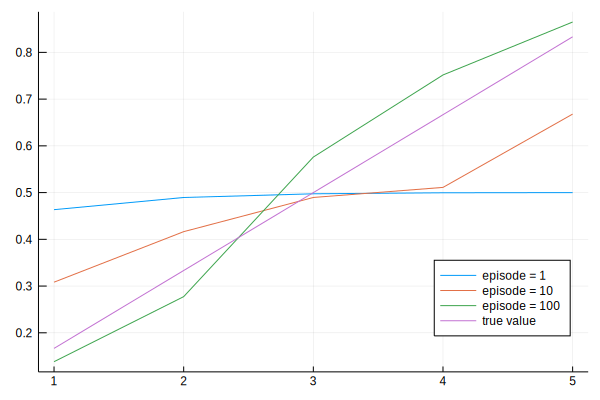

In [62]:
p = plot(;legend=:bottomright)
for i in [1, 10, 100]
    agent = create_TD_agent(0.1)
    run(agent, env, StopAfterEpisode(i))
    plot!(p, agent.π.learner.approximator.table[2:end - 1], label="episode = $i")
end
plot!(p, true_values, label="true value")
p

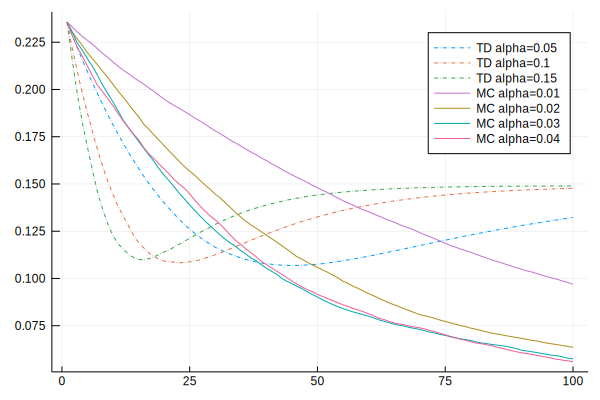

In [34]:
p = plot()

for α in [0.05, 0.1, 0.15]
    rms = []
    for _ in 1:100
        agent = create_TD_agent(α)
        hook = RecordRMS()
        run(agent, env, StopAfterEpisode(100);hook=hook)
        push!(rms, hook.rms)
    end
    plot!(p, mean(rms), label ="TD alpha=$α", linestyle=:dashdot)
end

for α in [0.01, 0.02, 0.03, 0.04]
    rms = []
    for _ in 1:100
        agent = create_MC_agent(α)
        hook = RecordRMS()
        run(agent, env, StopAfterEpisode(100);hook=hook)
        push!(rms, hook.rms)
    end
    plot!(p, mean(rms), label ="MC alpha=$α")
end

p

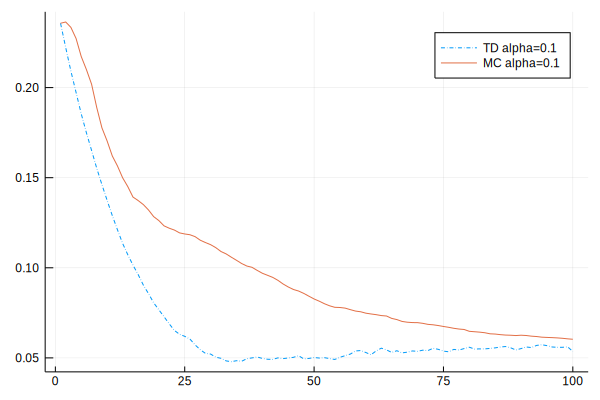

In [63]:
p = plot()

rms = []
for _ in 1:100
    agent = create_TD_agent(0.1)
    hook = RecordRMS()
    run(agent, env, StopAfterEpisode(100);hook=hook)
    push!(rms, hook.rms)
end
plot!(p, mean(rms), label ="TD alpha=0.1", linestyle=:dashdot)


rms = []
for _ in 1:100
    agent = create_MC_agent(0.1)
    hook = RecordRMS()
    run(agent, env, StopAfterEpisode(100);hook=hook)
    push!(rms, hook.rms)
end
plot!(p, mean(rms), label ="MC alpha=0.1")

p